In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import scipy

In [2]:
def N_avg(a, N=7):
    # weekly avg into the past, shorten a
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

def N_avg_hard(a, N=3):
    # hard edged rolling avg, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    b[:] = np.nan
    for i in range(N,len(a)-N,1):
        b[i] = np.mean(a[i-N:i+N])
    return b

def N_avg_soft(a, N=3):
    # soft edged rolling avg, preseve len a 
    b = np.zeros(len(a))
    for i in range(len(a)):
        l = max(0,i-N)
        r = min(i+N+1, len(a))
        b[i] = np.mean(a[l:r])
    return b

def diff_axis(scale, ax1, ax2):
    _,l1 = ax1.get_ylim()
    _,l2 = ax2.get_ylim()
    d1 = np.array(ax1.lines[0].get_ydata())
    d2 = np.array(ax2.lines[0].get_ydata())
    return np.mean(np.abs(d1/scale-d2))
    
def match_axis(ax1, ax2):
    scale = scipy.optimize.minimize(diff_axis, 1, args=(ax1,ax2))
    _,l2 = ax2.get_ylim()
    ax1.set_ylim(0,l2*scale.x)  
    return scale.x

In [3]:
# download api data for England
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_england = pd.DataFrame(response['body'])
df_england['dateTime'] = pd.to_datetime(df_england['date'])
df_england.sort_values(by=['dateTime'], inplace=True)
df_england.dropna(inplace=True)

top_date = sorted(list(set(df_england.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date)

2021-12-27


In [4]:
# download api data for regions 
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=region&metric=newCasesBySpecimenDate&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_cases = pd.DataFrame(response['body'])
df_regions_cases['dateTime'] = pd.to_datetime(df_regions_cases['date'])
df_regions_cases.sort_values(by=['dateTime'], inplace=True)
df_regions_cases.dropna(inplace=True)

top_date_cases = sorted(list(set(df_regions_cases.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_cases)

req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nhsRegion&metric=newAdmissions&format=json"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df_regions_nhs = pd.DataFrame(response['body'])
df_regions_nhs['dateTime'] = pd.to_datetime(df_regions_nhs['date'])
df_regions_nhs.sort_values(by=['dateTime'], inplace=True)
df_regions_nhs.dropna(inplace=True)

top_date_nhs = sorted(list(set(df_regions_nhs.dateTime.to_list())))[-1].strftime("%Y-%m-%d")
print(top_date_nhs)

top_date = min(top_date_cases, top_date_nhs)

2021-12-28
2021-12-27


In [5]:
# input defs
train_in_stream = []
train_out_stream = []
dates_train = []
test_in_stream = []
test_out_stream = []
dates_test = []

in_event = ""
out_event = ""
geographical_context = ""

train_start_date = "2020-11-15" 
train_end_date = "2021-03-01"
test_start_date = "2021-10-15"
test_end_date = top_date

#train_start_date = "2021-07-01" 
#train_end_date = "2021-12-01"
#test_start_date = "2021-10-01"
#test_end_date = top_date

In [6]:
# set data: England +ve tests -> hosp admissions
df = df_england
train_df = df[(df.dateTime >= train_start_date) & (df.dateTime <= train_end_date)]
test_df = df[(df.dateTime >= test_start_date) & (df.dateTime <= test_end_date)]

train_in_stream = np.array(train_df.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df.dateTime.to_list())))
dates_test = sorted(list(set(test_df.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = "England"

In [7]:
# set data: Regional +ve tests -> hosp admissions
region = "London"
df_c = df_regions_cases[df_regions_cases.areaName==region]
df_n = df_regions_nhs[df_regions_nhs.areaName==region]

train_df_c = df_c[(df_c.dateTime >= train_start_date) & (df_c.dateTime <= train_end_date)]
train_df_n = df_n[(df_n.dateTime >= train_start_date) & (df_n.dateTime <= train_end_date)]
test_df_c = df_c[(df_c.dateTime >= test_start_date) & (df_c.dateTime <= test_end_date)]
test_df_n = df_n[(df_n.dateTime >= test_start_date) & (df_n.dateTime <= test_end_date)]

train_in_stream = np.array(train_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
train_out_stream = np.array(train_df_n.newAdmissions.to_list(), dtype=float)
test_in_stream = np.array(test_df_c.newCasesBySpecimenDate.to_list(), dtype=float)
test_out_stream = np.array(test_df_n.newAdmissions.to_list(), dtype=float)
dates_train = sorted(list(set(train_df_c.dateTime.to_list())))
dates_test = sorted(list(set(test_df_c.dateTime.to_list())))

#train_in_stream = N_avg(train_in_stream)
#train_out_stream = N_avg(train_out_stream)
#test_in_stream = N_avg(test_in_stream)
#test_out_stream = N_avg(test_out_stream)

in_event = "+ve test"
out_event = "admitted"
geographical_context = region

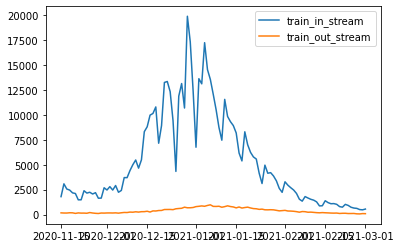

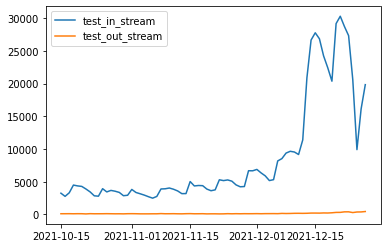

In [8]:
plt.clf()
plt.plot(dates_train, train_in_stream, label="train_in_stream")
plt.plot(dates_train, train_out_stream, label="train_out_stream")
plt.legend()
plt.show()
plt.clf()
plt.plot(dates_test, test_in_stream, label="test_in_stream")
plt.plot(dates_test, test_out_stream, label="test_out_stream")
plt.legend()
plt.show()

In [9]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=train_in_stream, out_stream=train_out_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [10]:
n_dim = 40
n_particles = 1000

x_max = 0.03*np.ones(n_dim)
x_min = -0.005*np.ones(n_dim)
options = {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

_minimizers = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    _minimizers.append(pos)
minimizers = np.array(_minimizers)

2021-12-30 16:37:46,887 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=23.5
2021-12-30 16:37:53,052 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 23.47985276180959, best pos: [ 5.33840453e-03  3.77618734e-03  5.05430139e-03  5.67948464e-03
  4.59536811e-03  6.71648339e-03  7.68969165e-03  5.54756030e-03
  6.11183137e-04  1.46383706e-03  3.25969938e-03  9.49097023e-05
  3.08758526e-03  1.17724142e-04  5.18715024e-03  1.97985432e-03
  2.09795993e-03 -5.70436538e-04  2.59853428e-04 -2.17467047e-03
  2.04139451e-04  6.46935809e-04  1.87895845e-03  1.00607103e-03
 -3.25549978e-04 -2.63333506e-04  3.45258869e-03 -1.04177670e-03
  3.78905520e-05  3.72593290e-03 -1.09882878e-03 -7.97803917e-04
  7.06132386e-04  9.01121715e-04  5.70723245e-04 -3.98975167e-04
  8.15444513e-04 -8.30952950e-04 -8.04709524e-06  1.76818767e-03]
2021-12-30 16:37:53,061 - 

2021-12-30 16:39:10,703 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=23.1
2021-12-30 16:39:20,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 23.12638468707368, best pos: [ 3.98113378e-03  4.99430038e-03  4.39716390e-03  1.08517557e-03
  8.09048615e-03  2.24222515e-03  7.88469818e-03  8.82805576e-03
  1.22982946e-03  1.92418153e-03  5.37877472e-03  1.32931622e-03
  2.13410926e-03  1.73411186e-03  3.36701749e-03  5.71478819e-04
  3.19263776e-03  3.37077899e-03 -1.14797421e-03  4.40823745e-04
  4.48058929e-04  1.44490253e-03 -1.11200087e-03 -2.38077783e-03
 -6.93440529e-04 -8.53528196e-04 -4.03986849e-05  1.69484960e-03
  1.57377803e-03  7.51607480e-04  2.11642891e-03  4.28899357e-04
  1.92039827e-04  1.51064714e-03 -3.90942403e-04  2.80127479e-04
  1.80036145e-03 -7.91344007e-07 -1.48615279e-03  5.34448491e-04]
2021-12-30 16:39:20,543 - 

2021-12-30 16:40:37,475 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=23 
2021-12-30 16:40:44,420 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 22.992312482768543, best pos: [ 2.24998855e-03  8.13218882e-03  3.02694127e-03  4.73435991e-03
  3.86018607e-03  7.55237113e-03  6.40659595e-03  3.34208516e-03
  7.10837315e-03  1.20303610e-03  3.44752457e-03  1.52579460e-03
  2.66883170e-04  8.26741516e-04  3.46960305e-03 -4.91236255e-04
  3.84787546e-03  1.26549284e-03  6.54232999e-04 -2.30106340e-03
  2.28842025e-03  3.65130387e-03  7.57109720e-04 -1.61941727e-03
  7.56451226e-04 -1.66394519e-03  1.48619225e-03  1.71608265e-04
  4.85902468e-05  8.25556362e-04 -1.49434814e-04  4.22298390e-04
 -3.44853330e-05  4.60015102e-04  1.44407230e-03  2.24206394e-04
  2.82952483e-03 -1.28212170e-03 -2.03463428e-03  2.27203621e-03]
2021-12-30 16:40:44,429 - 

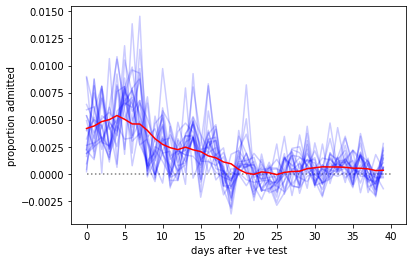

<Figure size 432x288 with 0 Axes>

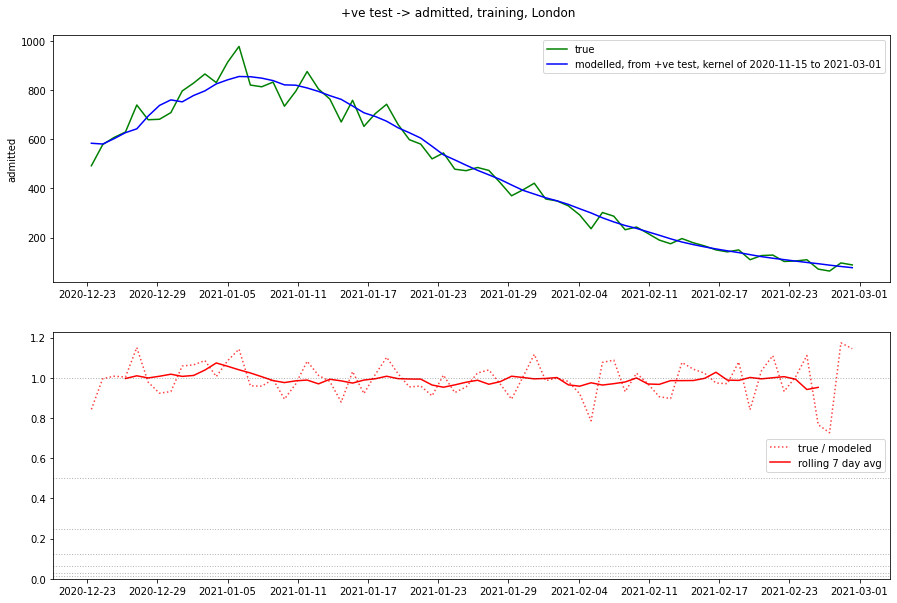

<Figure size 432x288 with 0 Axes>

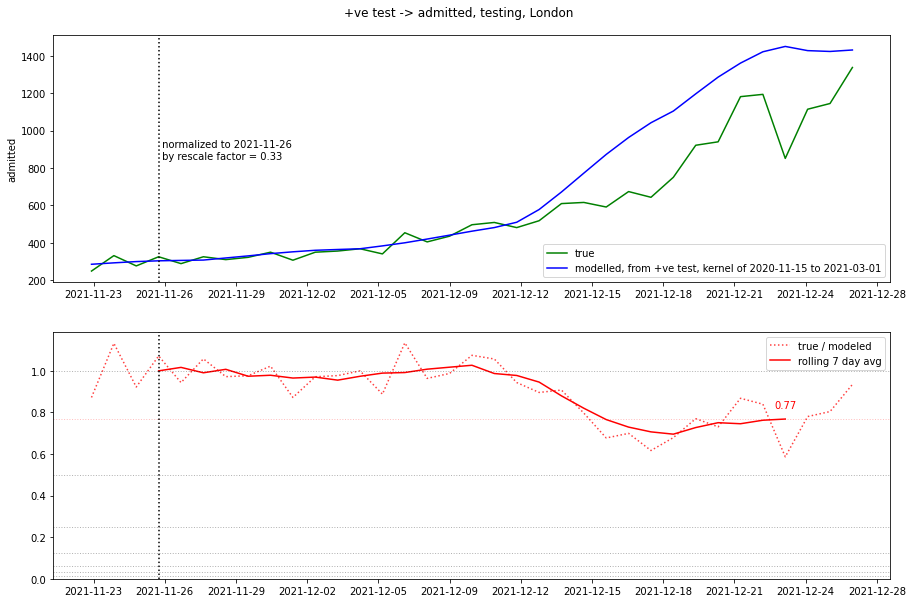

In [11]:
# show kernel
plt.clf()
z = list(range(len(pos)))
for y in minimizers:
    plt.plot(z, y, color="blue", alpha=0.2)
avg_minimizer = []
for i in range(len(minimizers[0])):
    avg_minimizer.append(np.mean(minimizers[:,i]))
avg_minimizer = np.array(avg_minimizer)
avg_minimizer = N_avg_soft(avg_minimizer, 3) 
plt.plot(z, avg_minimizer, color="red", alpha=1)
plt.xlabel("days after %s" % in_event)
plt.ylabel("proportion %s" % out_event)
plt.hlines(0, 0,len(z), ls="dotted", alpha=0.5, color="black")
plt.savefig("%s__%s__kernel__%s.png" % (in_event, out_event, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

#print("mass: %.2f" % np.sum(avg_minimizer))

# show fit to training & testing
def make_graph(dates, kernel, in_stream, out_stream, test_train):
    plt.clf()
    assert(len(in_stream)==len(out_stream))
    assert(len(kernel)<=len(in_stream))
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    ax1,ax2 = axes   
    
    true, pred = _f(avg_minimizer, in_stream, out_stream) 
    x = dates[-len(true):]
    diff = true/pred
    avg_diff = N_avg_hard(diff, 3)
    rescale_factor = 1
    if test_train=="test":
        rescale_factor = avg_diff[np.isfinite(avg_diff)][0]
    
    ax1.plot(x, true/rescale_factor, color="green", label="true")
    modeled_label = "modelled, from %s, kernel of %s to %s" % (in_event, train_start_date, train_end_date)
    ax1.plot(x, pred, color="blue", label=modeled_label)
    ax1.set_ylabel("%s" % out_event)
    ax1.legend()
    n_marks = 11
    ax1.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))
    
    ax2.plot(x, diff/rescale_factor, color="red", alpha=0.75, ls="dotted", label="true / modeled")
    ax2.plot(x, avg_diff/rescale_factor, color="red", label="rolling 7 day avg")
    for i in range(7):
        ax2.axhline(y=2**(-i), ls="dotted", lw=1, alpha=0.3, color="black")        
    ax2.set_ylim(0,None)
    ax2.legend()
    ax2.xaxis.set_major_locator(ticker.MultipleLocator(len(x)/n_marks))

    if test_train=="test":
        end_level = avg_diff[np.isfinite(avg_diff)][-1]
        ax2.axvline(x=x[3], color="black", ls="dotted")
        ax1.axvline(x=x[3], color="black", ls="dotted")
        y_min,y_max = ax1.get_ylim()
        y_mid = (y_min+y_max)/2 
        ax1.text(x[3], y_mid, " normalized to %s\n by rescale factor = %.2f" % (x[3].strftime("%Y-%m-%d"), rescale_factor), ha="left")
        ax2.axhline(y=end_level/rescale_factor, color="red", alpha=0.25, ls="dotted", lw=1)
        ax2.text(x[-4], end_level/rescale_factor+0.05, "%.2f" % (end_level/rescale_factor), ha="center", color="red")    
    
    fig.suptitle("%s -> %s, %sing, %s" % (in_event, out_event, test_train, geographical_context), y=0.92)
    plt.savefig("%s__%s__%s__%s.png" % (in_event, out_event, test_train, geographical_context), bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()
    
make_graph(dates_train, avg_minimizer, train_in_stream, train_out_stream, "train") 
make_graph(dates_test, avg_minimizer, test_in_stream, test_out_stream, "test") 




In [12]:
print(avg_minimizer)

[ 4.18319465e-03  4.41479366e-03  4.82063052e-03  5.00031530e-03
  5.37923762e-03  5.03188225e-03  4.60341876e-03  4.59338926e-03
  3.99834102e-03  3.23755980e-03  2.70996760e-03  2.40479817e-03
  2.22915835e-03  2.45622775e-03  2.21282793e-03  2.04785296e-03
  1.65048815e-03  1.47149985e-03  1.08708570e-03  9.17237385e-04
  3.97891882e-04  5.42138508e-05 -5.82848371e-05  1.66328996e-04
  9.03689401e-05 -8.15560412e-05  1.23992274e-04  2.04150145e-04
  2.30429567e-04  4.72404237e-04  5.49840009e-04  6.38995094e-04
  6.24200531e-04  6.23062797e-04  5.94163520e-04  5.11805126e-04
  5.07042800e-04  4.48693296e-04  2.93486829e-04  3.22085145e-04]
